# Test DRDV Policy  with Engine Failure

In [1]:
import numpy as np
import os,sys



sys.path.append('../../../RL_lib/Agents/PPO')
sys.path.append('../../../RL_lib/Utils')
sys.path.append('../../../Mars3dof_env')

%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/RL_Meta-Learning-master/Experiments/Mars3DOF/Engine_failure


In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

3-dof dynamics model
lander model apf
queue fixed
Flat Constraint


<IPython.core.display.Javascript object>


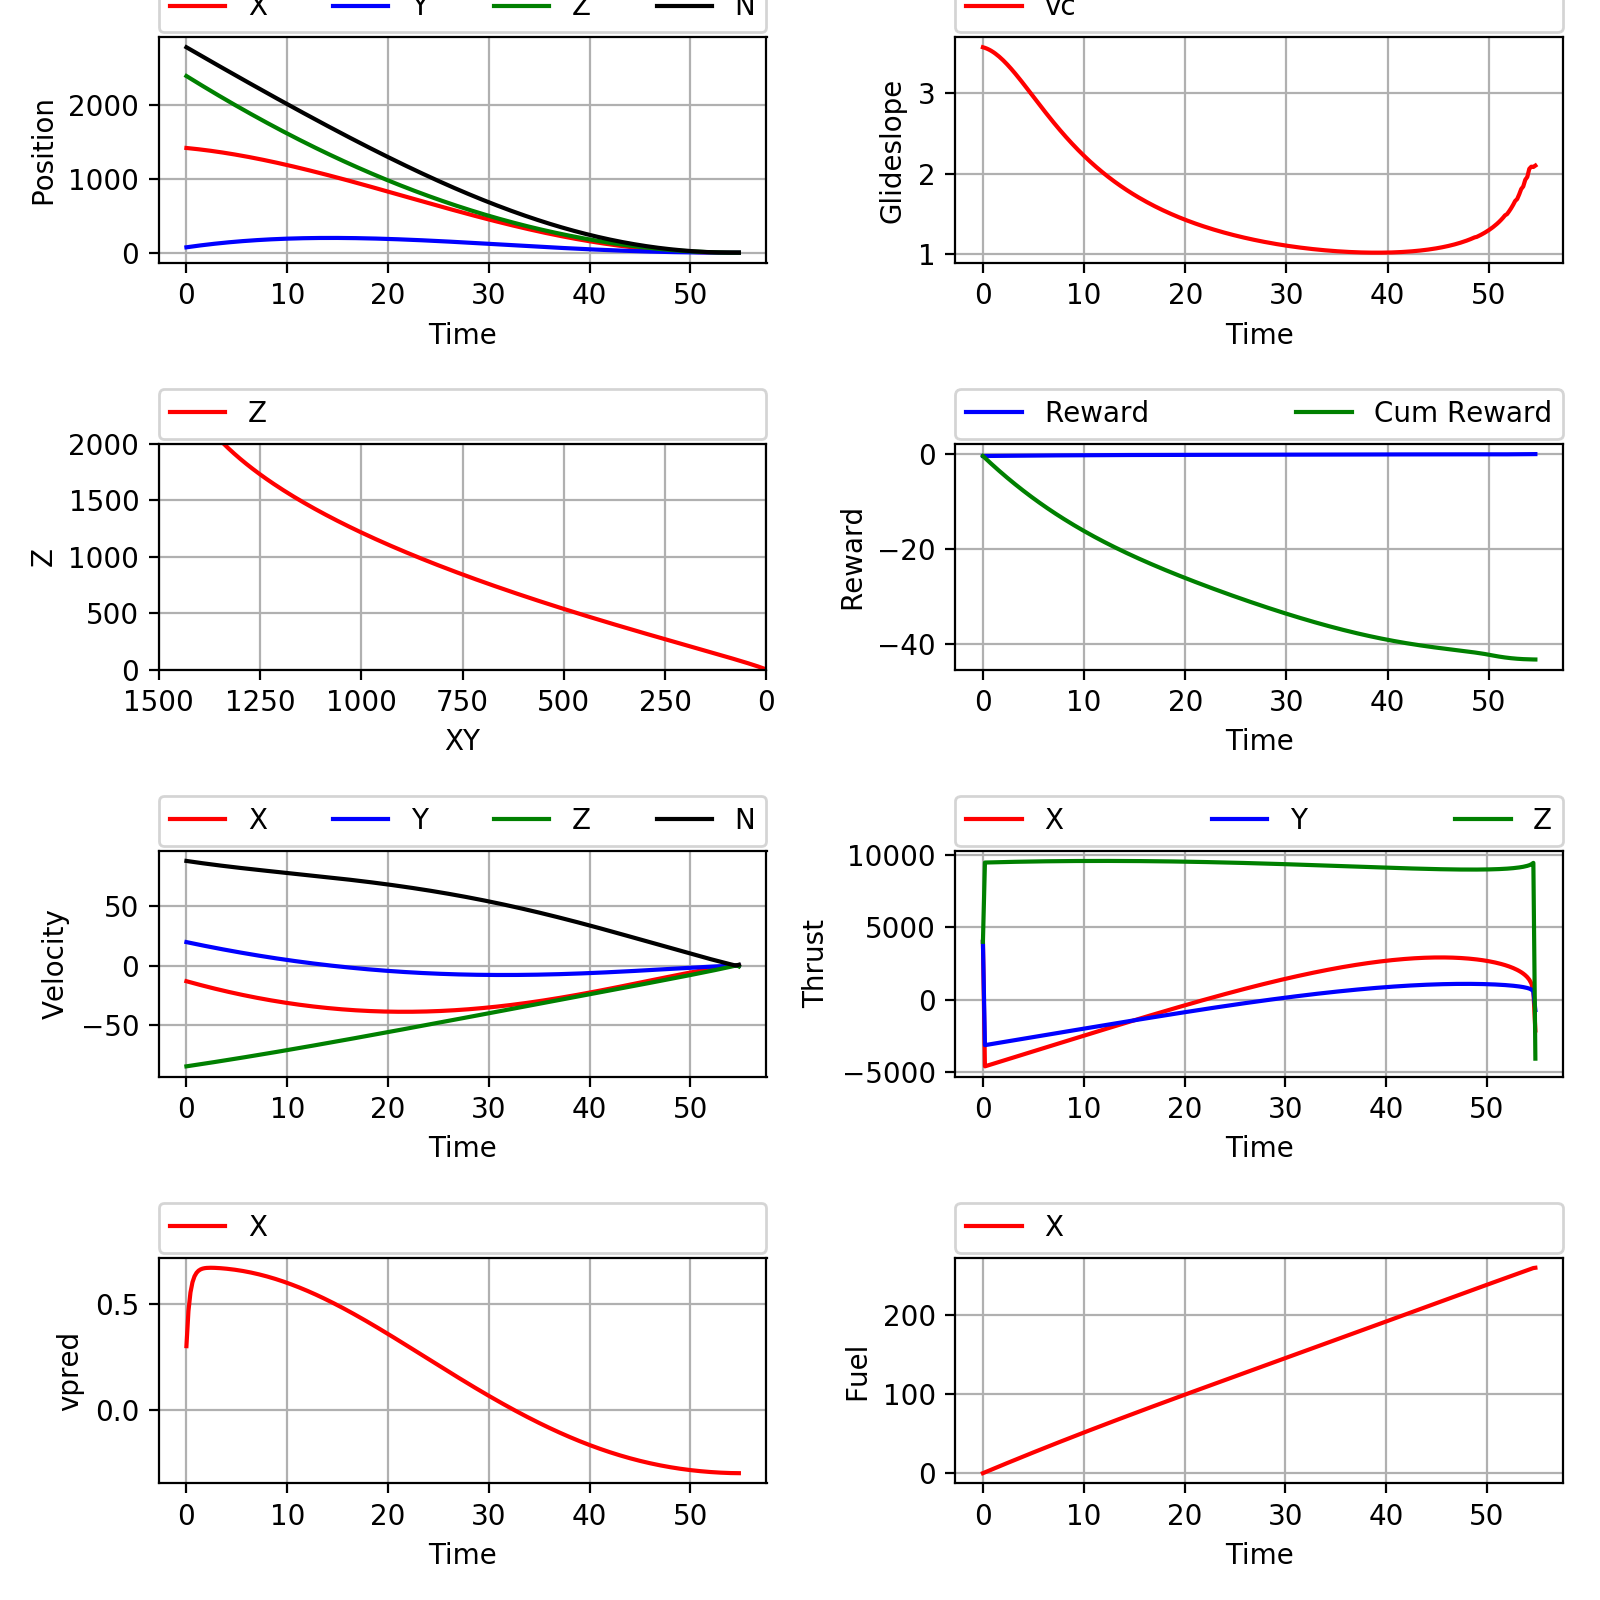

<IPython.core.display.Javascript object>


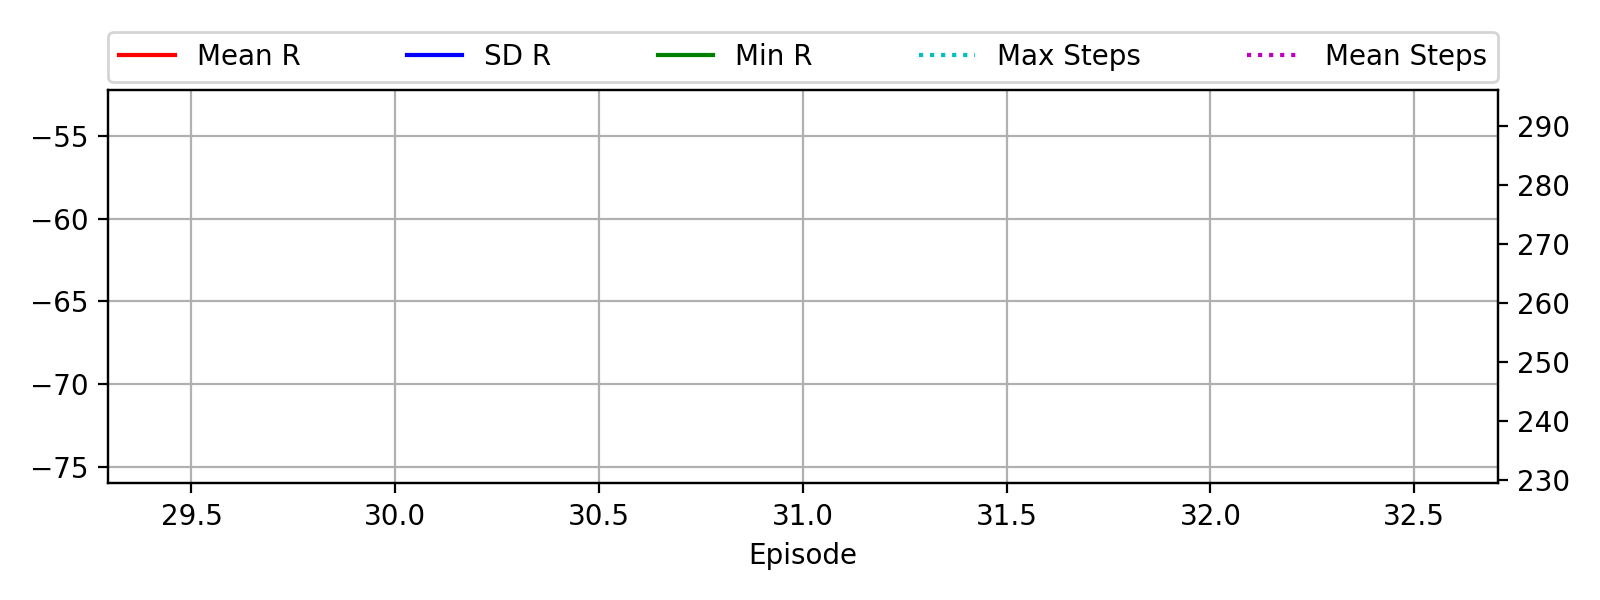

<IPython.core.display.Javascript object>


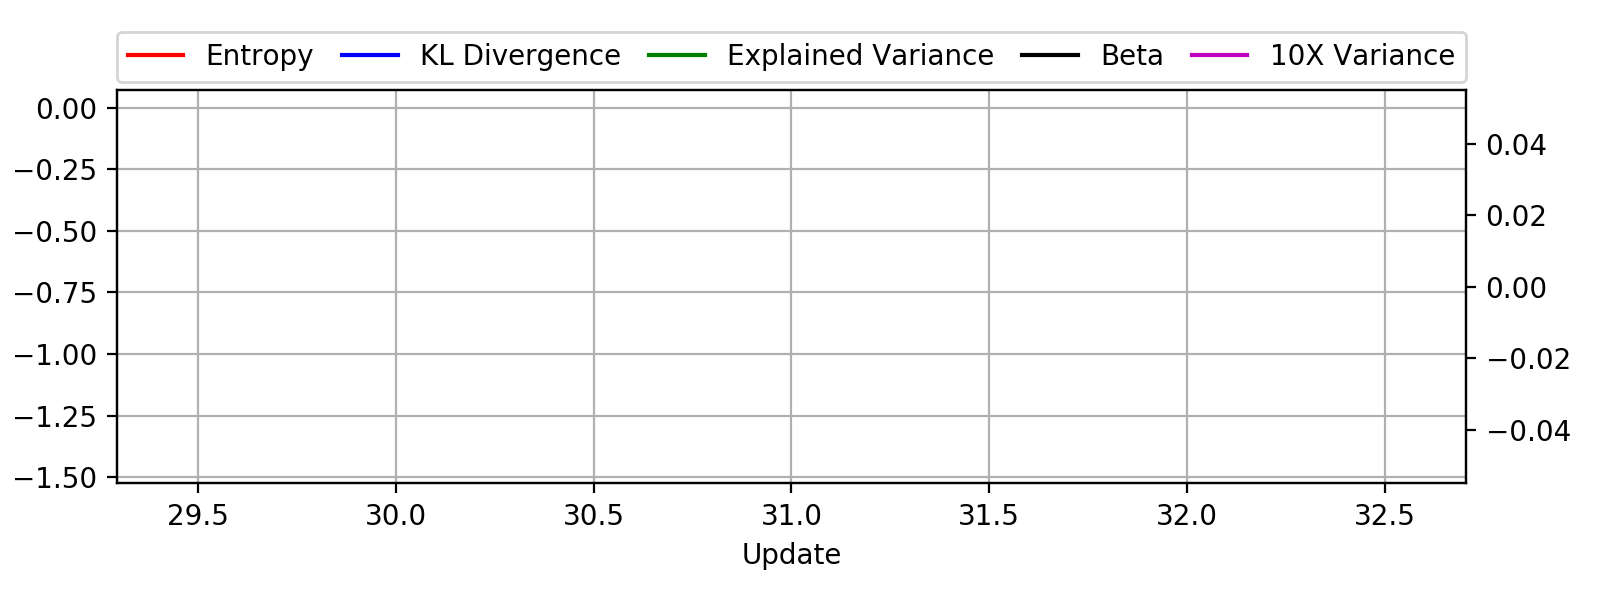

<IPython.core.display.Javascript object>


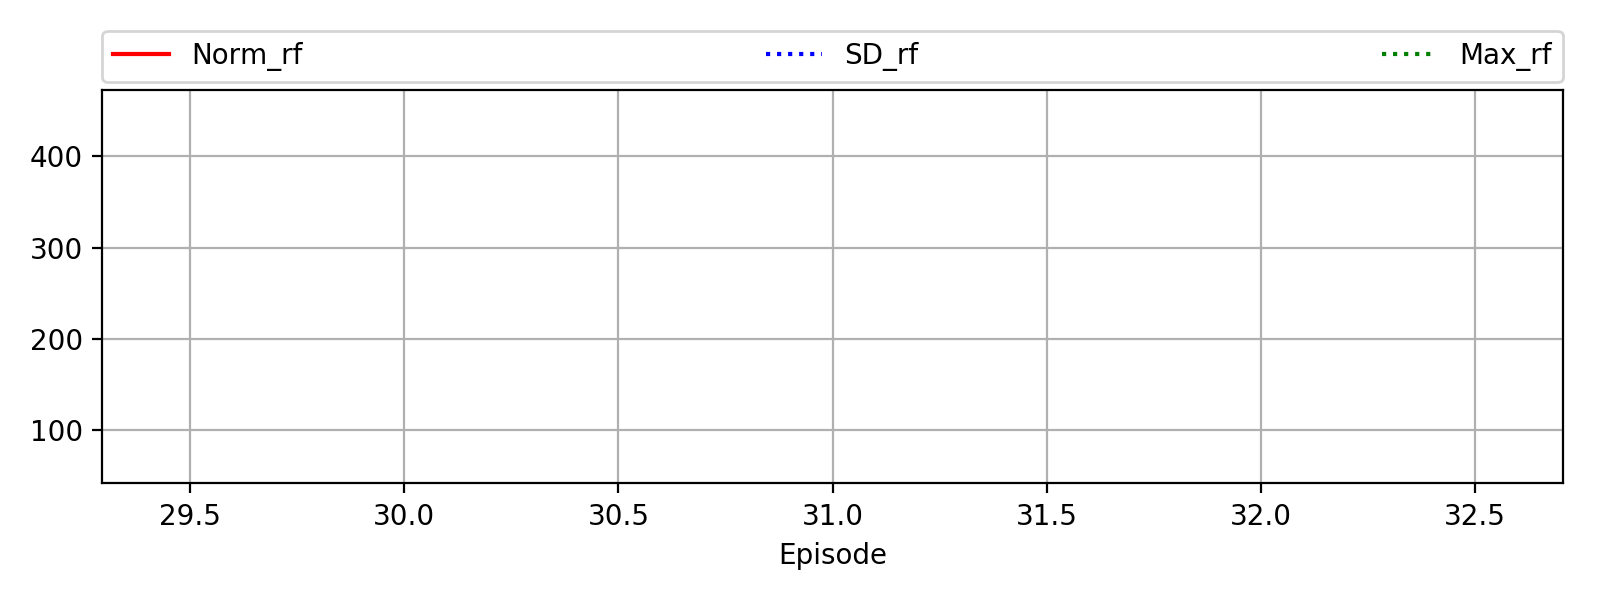

<IPython.core.display.Javascript object>


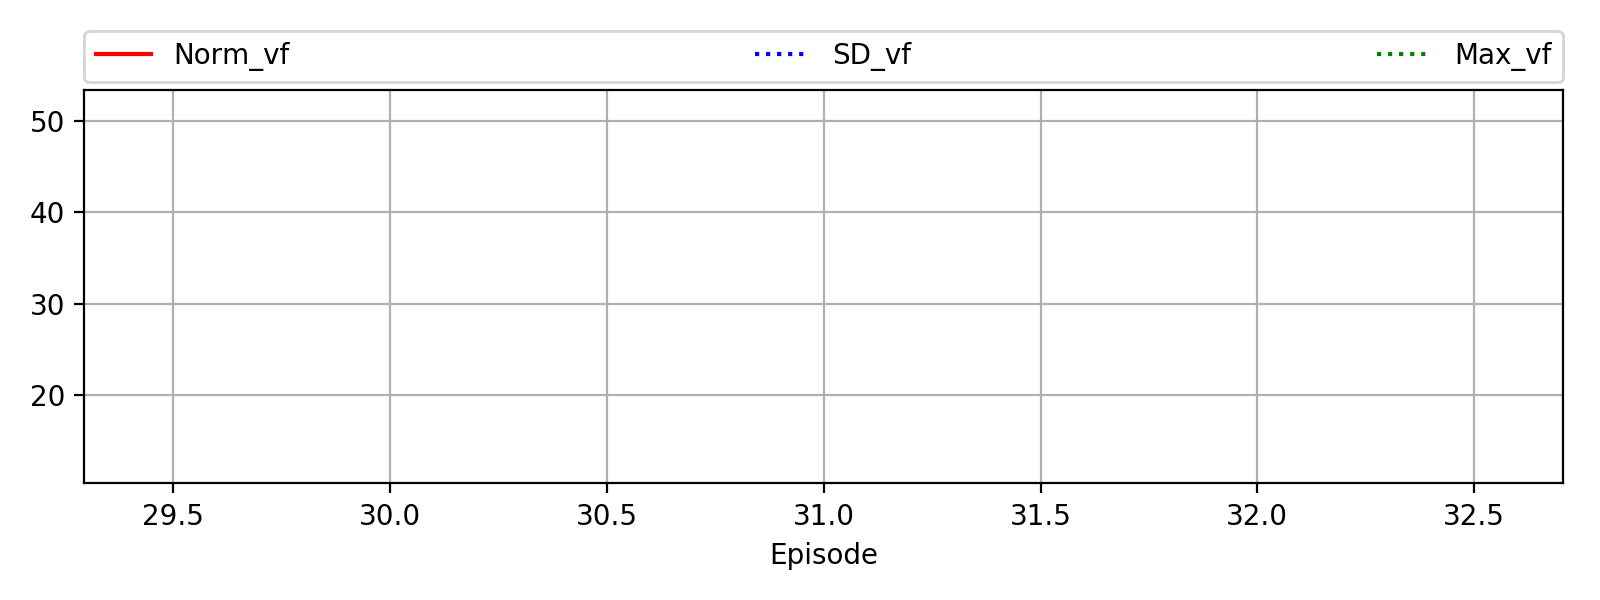

Lander Env
Landing_icgen:
    nominal_g                   :  -3.7114
    downrange                   :  (0, 2000, -70, -10)
    crossrange                  :  (-1000, 1000, -30, 30)
    altitude                    :  (2300, 2400, -90, -70)
    adjust_apf_v0               :  True
Value Funtion
	xn_init: layer  Linear(in_features=6, out_features=60, bias=True)
	xn_init: layer  GRUCell(60, 17)
	xn_init: layer  Linear(in_features=17, out_features=5, bias=True)
	xn_init: layer  Linear(in_features=5, out_features=1, bias=True)
Value Function: recurrent steps > 1, disabling shuffle and batching
	Clip Range:         0.5
	Shuffle :           False
	Batch Size :        9999999
	Max Grad Norm:      30
	Recurrent Steps:    20
	Rollout Limit:      1
Agent
*** SCALER WARMUP COMPLETE *** 
ValFun  Gradients: u/sd/Max/C Max/Max u/Max sd :   0.2558   0.3044   1.2965   1.2965   0.2558   0.3044
Update Cnt = 0    ET =     29.2   Stats:  Mean, Std, Min, Max
r_f      |    27.3    20.5    -0.2 |    93.0    91

In [4]:
from env_killengine_test import Env
import env_utils as envu
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen2 import Landing_icgen
import rl_utils

from arch_policy_vf import Arch

from policy_drdv import Policy
from value_function import Value_function

import policy_nets as policy_nets
import valfunc_nets as valfunc_nets

from agent import Agent


import torch.nn as nn

from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from reward_terminal_mdr import Reward


logger = rl_utils.Logger()
dynamics_model = Dynamics_model()
lander_model = Lander_model(apf_tau1=20,apf_tau2=100,apf_vf1=-2,apf_vf2=-1,apf_v0=70,apf_atarg=15.)
lander_model.get_state_agent = lander_model.get_state_agent1
lander_model.max_thrust = 24000
lander_model.min_thrust = 4000
obs_dim = 6
act_dim = 3
recurrent_steps = 20

reward_object = Reward()

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          kill_lateral_scale=2.5,
          kill_vertical_scale=1.5,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          tf_limit=100.0,print_every=10,
          p_kill=0.5)

env.ic_gen = Landing_icgen(mass_uncertainty=0.05, 
                           g_uncertainty=(0.05,0.05),
                           adjust_apf_v0=True,
                          downrange = (0,2000 , -70, -10), 
                           crossrange = (-1000,1000 , -30,30),  
                           altitude = (2300,2400,-90,-70))
env.ic_gen.show()

arch = Arch()

policy = Policy(env)
value_function = Value_function(valfunc_nets.GRU(obs_dim, recurrent_steps=recurrent_steps), 
                                shuffle=False, batch_size=9999999, max_grad_norm=30)

agent = Agent(arch, policy, value_function, None, env, logger,
              policy_episodes=30, policy_steps=3000, gamma1=0.95, gamma2=0.995, lam=0.98, 
              recurrent_steps=recurrent_steps, monitor=env.rl_stats)
agent.train(3)

# Test Policy 

In [5]:
policy.test_mode=True
  
env.test_policy_batch(agent,1000,print_every=100)

i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |10432.02 |1961.36 |4000.00 |16574.79 |    29
glideslope | 2.428 | 2.154 | 0.493 |57.398 |    11
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |  22.328 |  19.868 |   0.003 |  55.328
norm_rf  |   157.2 |   229.6 |     0.0 |   862.7
position |    52.5     3.7    -0.4 |   191.5   195.0     0.5 |  -775.1  -636.5    -1.6 |   730.6   820.9    -0.0
velocity |  -9.745  -0.253 -16.666 |  13.852  10.528  14.757 | -41.167 -27.224 -39.434 |  11.471  28.497  -0.003
fuel     |207.57 | 42.92 |154.90 |305.19
glideslope |  2.15 |  1.51 |  0.49 |  9.02
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |10426.78 |1903.74 |4000.00 |24000.00 |   182
glideslope | 2.542 | 2.385 | 0.493 |67.246 |   110
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |  20.204 |  19.465 |   0.001 |  57.268
norm_rf  |   142.8 |   226.3 |     0.0 |  1120.7
position |    33